# Problem Introduction

### Nudging customers to payed products by utilizing data produced by apps

Companies often provide free premium product/services in an attempt to transition their customers to the premium membership. In this case study, the services offered by a mobile app are examined. Customers have a 24 hour frame of free premium membership. 

Our goal is to determine which users are less likely to subscribe to the paid membership so that greater marketing offers can be directed at them in a bid to make them premium customers. The company could then offer a free one-month trial or even better a 50% off yearly subscription so that they win them over as premium users. After all, if you are running marketing offers you don't want to offer them to cutomers who will anyway subsribe to the premium membership eh?

# Bird's eye view
As with many machine learning pipelines the roadmap has its similarities. Here is a bird's eye view of what steps we will go throw in this project.

1. Question and required data
2. Acquire the data
3. Data preprocessing: Taking care of missing data & annomalies
4. Prepare the data for the Machine Learning model
5. Train the model on the training data
6. Make predictions on the test data
7. Evaluate the model
8. If the performance is not satisfactory adjust the model. This often means acquiring more data, playing with hyperparameters or choosing a different model altogether.
9. Interpret the model and report results visually and numerically

In [1]:
# Standart Data Science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dateutil import parser

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

import seaborn as sn
sn.set()

# 2. The Data

The fields in the data describe what companies usually track from their users with real-world distribution and patterns. This data makes it possible to see the date and time of app installation as well as **most importantly**, the features with which the users engaged within the app. Thus we have a great insight of what is called *app behavior*: the list of app screens the user looked at.

### Explanations of the columns

1. <b>user:</b> an id identifying the user
2. <b>first_open:</b> the day and time that the user first oppened the app
3. <b>dayofweek:</b> day of the week in numerical form. 0-Sunday, 6-Saturday
4. <b>hour:</b> the hour of the day when the app was first oppened
5. <b>age:</b> the age of the customer
6. <b>screen_list:</b> every screen name visited by the user in the first 24 hours of premium membership 
7. <b>numscreens:</b> the number of screens visited by the user
8. <b>minigame:</b> whether the players played a game offered by the app
9. <b>used_premium_feature:</b> whether the user has used the premium features even though he had them for free the first 24h hours
10. <b>enrolled:</b> whether the user enrolled for premium
11. <b>enrolled_date:</b> the date they enrolled. This is the only feature which is not restricted to the first 24h
12. <b>liked:</b> whether the user hit the like button (for at least one feature)

In [2]:
features = pd.read_csv("data/appdata10.csv")
features.sample(6)

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
43429,339127,2013-06-09 01:20:42.235,6,01:00:00,48,"idscreen,product_review,product_review,product...",5,1,0,1,2013-06-15 16:13:30.250,0
41968,27619,2013-07-02 19:05:08.744,1,19:00:00,22,"idscreen,Home,Loan3,product_review,product_rev...",19,0,0,1,2013-07-02 19:33:58.202,0
4188,197447,2013-02-24 06:08:27.136,6,06:00:00,33,"joinscreen,product_review,product_review2,Scan...",33,0,0,1,2013-02-24 06:11:24.569,1
21206,235072,2012-12-28 17:58:19.712,4,17:00:00,33,"product_review,ScanPreview,Loan2,product_revie...",6,0,0,0,NaN,1
48309,139248,2013-03-11 08:19:42.423,0,08:00:00,23,"joinscreen,product_review,product_review2,Scan...",15,0,0,1,2013-03-11 08:21:39.173,0
33227,42762,2013-04-14 04:41:55.032,6,04:00:00,42,"idscreen,Home,product_review,product_review,pr...",23,1,0,0,NaN,0


# 3. Data Preprocessing

1. Tidy Data
2. Missing Data
3. Outliers
4. Class-Imbalance Problem
5. Feature correlation

## Tidy Data
The data seems to already be [tidy](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html).

## Missing Data & Outliers
A great way to identify both missing data and outliers is computing summary statistics on our dataframe.

In [3]:
print("The shape of our dataset is:", features.shape)
features.describe()

The shape of our dataset is: (50000, 12)


,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


Considering our domain knowledge, there seem not to be any outliers with our data. 

Additionally, visualizing the features always helps. 

In [4]:
# Convert the hour feature to int
# astype casts a pandas type to the specified datatype
features['hour'] = features['hour'].str.slice(1,3).astype(int)

Visualizing features also helps in **getting comfortable with the data** which is a crucial step for any data scientist in his quest to get insight from data.

In [5]:
features_temp = features.drop(columns=['user', 'screen_list', 'enrolled_date', 'first_open', 'enrolled'],
                             axis=1, inplace=False)
features_temp.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


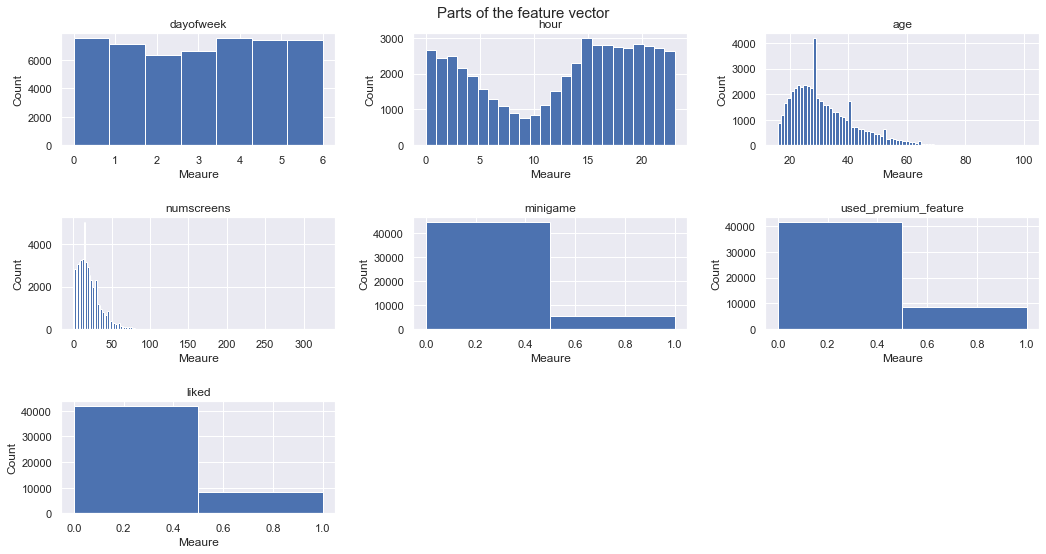

In [6]:
plt.figure(figsize=(15,8))

# Set the title for all plots
plt.suptitle("Parts of the feature vector", fontsize=15)

# The loop starts from 1 because the subplot function requires it so
for i in range(1, features_temp.shape[1]+1):
    # Add a subplot
    plt.subplot(3,3,i)
    
    # Get the current plot
    figure = plt.gca()
    
    # Set the title of the current plot
    figure.set_title(features_temp.columns[i-1])
    
    # Specify bins to be the number of unique values/features to make the plot better looking
    f_bins = np.size(features_temp.iloc[:, i-1].unique())
    
    plt.hist(features_temp.iloc[:,i-1], bins=f_bins)
    plt.xlabel("Meaure")
    plt.ylabel("Count")
    
# Give some padding to avoid overlap in graphs
plt.tight_layout(pad=2)

Again, **getting comfortable with the data** is quite important. Here for the binary attributes *minigame*, *used_premium_feature* and *liked* we can basically see that most of the users did not play the minigame use the premium features or liked any features. 

Then we can see that regarding days of the week, things stand pretty much even. With *hours* we have a quiet time which should be the night. As of age, most of our users seem to be late 20s, early 30s.

### To sum up there seem to be no outliers

In [7]:
print(features.isnull().sum())

user                        0
first_open                  0
dayofweek                   0
hour                        0
age                         0
screen_list                 0
numscreens                  0
minigame                    0
used_premium_feature        0
enrolled                    0
enrolled_date           18926
liked                       0
dtype: int64


### There also seem not to be any missing data

## Class Imbalance Problem

In [8]:
print("There seems to be no class imbalance problem.")
print(features['enrolled'].value_counts() / features.shape[0])

There seems to be no class imbalance problem.
1    0.62148
0    0.37852
Name: enrolled, dtype: float64


## Feature Correlation
A high correlation between two features indicates that there is redundancy and one of them can be ignored. Moreover such features would most likely ruin our model.

### Correlation with the class variable
Lets check out a kind of variable importance analysis where we see the correlation between the features and the class variable (enrolled).

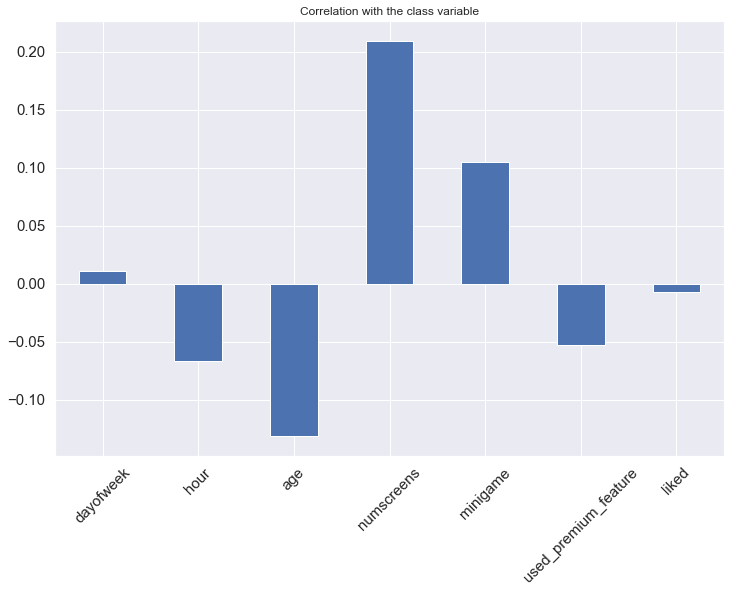

In [9]:
# Plot with pandas
features_temp.corrwith(features['enrolled']).plot.bar(figsize=(12, 8), title='Correlation with the class variable',
                                                     rot=45, fontsize=15)
plt.show()

The most important variable (in terms of correlation) seems to be *numscreens*. The more features the users have tried out, the more likely they seem to be to enroll for premium. Playing the minigame also helps.

Interestingly, however, using more premium features seems to be negatively correlated. This is strange.

### Correlation Matrix: Correlation of features with each-other.
As already mentioned, we do not want our features to be correlated with each-other. Not only are those features redundant but moreover they might ruin our model. The assumption when building machine learning models is that features are independent from each-other.

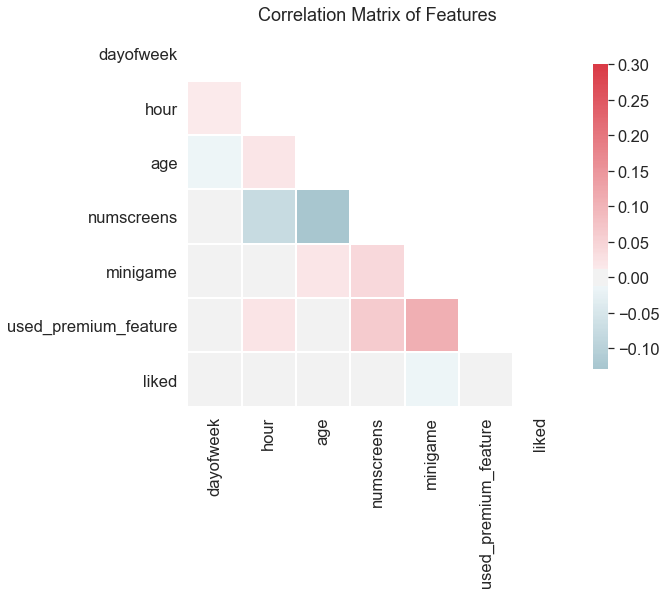

In [10]:
sn.set(style='white', font_scale=1.5)

# Compute the correlation matrix
# The correlation matrix is an array where the main diagonal separetes two identical triangles
corrMatrix = features_temp.corr()

# Create a mask for the upper triangle so that we can ignore it later when building the heatmap
# When we pass this mask to the heatmap function it will generate no data for the upper triangle
mask = np.zeros_like(corrMatrix, dtype=np.bool)
# Get the indices of the upper-triangle of arr: triu_indices_from
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
# Colormap for the different values of the correlation matrix
cmap = sn.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(9, 7))
plt.title("Correlation Matrix of Features")

# Draw the heatmap
sn.heatmap(corrMatrix, square=True, mask=mask, cmap=cmap, vmax=.3, center=0, linewidths=1.0,
          cbar_kws={"shrink": 0.8})

plt.show()

We can see that *numscreens* seems to be slightly correlated with *minigame* and *used_premium_features* which makes sense since the more screens you go through the more likely you should be to hit those types of screens. It also makes sense that *minigame* is correlated to the premium features.

All in all we can say that our variables do not appear to be linearly dependent and we can continue our analysis.

# 4. Prepare the data for the Machine Learning Model

1. Feature Engineering
2. One-Hot Encoding
3. Class and Features
4. Train/Test
5. Feature Scaling

## Feature Engineering

What we want to do is fine tune the *enrolled* variable. We need to set a threshold on when we expect a user to convert to a paid member. If we do not set a threshold we cannot validate our model for future datasets and on production we want to predict continually and not wait weeks or months before making a prediction. For e.g., if we have a time limit of 3 days for enrollments to be considered then we only need to wait 3 days after the users have installed the app to make a prediction (whether the user is unlikely to subscribe) and thus the marketing people can target them with offers. 

In [11]:
features.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                     int32
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

First, convert the dates to date type.

In [12]:
features['first_open'] = [parser.parse(date) for date in features['first_open']]

features['enrolled_date'] = [parser.parse(date) if isinstance(date, str) else date for date in features['enrolled_date']]


In [13]:
features.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int32
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

Now that we converted the dates into their proper type we can plot a distribution of the time since enrolled in a bid to find a threshold.

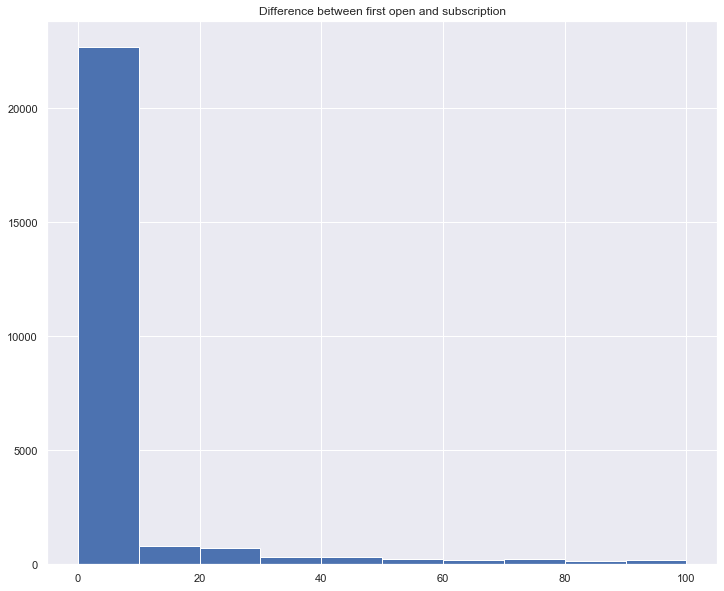

In [14]:
# Calculate the absolute difference and convert it to hours
features['difference'] = abs((features['first_open'] - features['enrolled_date']).astype('timedelta64[h]'))

# Plot
sn.set()
plt.figure(figsize=(12,10))
plt.hist(features['difference'].dropna(), range=[0,100])
plt.title("Difference between first open and subscription")
plt.show()

Pretty much everything happens within the first 10 hours but lets set a threshold of 48 hours for training our model. In other words we will train our model based on data gathered from users which decided if they wanted to subscribe to premium within the first 48 hours. This means that when our model reaches production, every time a user installs the app and is granted the premium features for free our model will yield an answer as to how likely this user is to continue using these premium features (therefore subscribing) after two days.

In [15]:
# Remove the records which have a greater difference
features.drop(index=features[features['difference']>48].index, axis=0, inplace=True)

# Drop columns that are no longer needed
features.drop(columns=['difference', 'enrolled_date', 'first_open'], axis=1, inplace=True)

print("Shape of our dataframe",features.shape)

Shape of our dataframe (43713, 10)


## One-Hot Encoding
Essentially [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) means converting categorical data into numerical data. 

In this case our most promising feature, *screen_list* is a categorial attribute.

In [16]:
features[['screen_list', 'numscreens']]

,screen_list,numscreens
0,"idscreen,joinscreen,Cycle,product_review,ScanP...",15
1,"joinscreen,product_review,product_review2,Scan...",13
2,"Splash,Cycle,Loan",3
3,"product_review,Home,product_review,Loan3,Finan...",40
4,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32
...,...,...
49995,"Splash,Home,ScanPreview,VerifyPhone,VerifySSN,...",13
49996,"Cycle,Splash,Home,RewardsContainer",4
49997,"joinscreen,product_review,product_review2,Scan...",25
49998,"Cycle,Home,product_review,product_review,produ...",26


In [17]:
print("Max number of screens in all samples:", max(features['numscreens']))

Max number of screens in all samples: 325


If we simply convert the *screen_list* categorical data into numerical features we will blow up the number of features. 

A better strategy is to find the most common screens and only portray them. While all the other, less common screens we put into one single column.

In [18]:
counter={}
for index, row in features.iterrows():
    screens = row['screen_list'].split(",")
    
    for sc in screens:
        if sc not in counter.keys():
            counter[sc]=1
        else:
            counter[sc]+=1

# Sort
counter = {k: v for k, v in sorted(counter.items(), key=lambda item: item[1], reverse=True)}

# Pick the top screens
top_screens = np.array([key for key, val in counter.items()])[:80]
top_screens

array(['product_review', 'Home', 'ScanPreview', 'VerifyPhone', 'location',
       'Loan2', 'VerifyDateOfBirth', 'VerifySSN', 'VerifyCountry',
       'VerifyToken', 'product_review3', 'SelectInstitution', 'Cycle',
       'idscreen', 'product_review2', 'Credit3Container',
       'BankVerification', 'Institutions', 'joinscreen', 'Credit1',
       'Credit3Dashboard', 'Splash', 'ReferralContainer', 'ProfilePage',
       'Loan3', 'Credit2', 'Credit3', 'Loan1', 'CC1', 'RewardsContainer',
       'Finances', 'MLWebView', 'CommunityAndInvites', 'Settings',
       'Alerts', 'CC1Category', 'Saving9', 'VerifyMobile', 'Saving8',
       'Leaderboard', 'Saving1', 'EditProfile', 'Saving10',
       'ProfileMaritalStatus', 'ProfileChildren', 'VerifyHousing',
       'Saving4', 'ProfileEducation', 'VerifyHousingAmount',
       'ProfileEducationMajor', 'ProfileVerifySSN', 'GroupedInstitutions',
       'History', 'RewardDetail', 'CC3', 'AccountView', 'Saving7',
       'Rewards', 'Rewardjoinscreen', 'LoginFor

The strategy here is basically to create features for the popular screens and for the rest to just create one single feature

In [19]:
# This will be needed later, just add one comma
features['screen_list'] = features['screen_list'].astype(str)+','

# Add new columns for the top screens
for sc in top_screens:
    # Add a 1 or 0 if the screen is found in the screen list
    features[sc] = features['screen_list'].str.contains(sc).astype(int)
    # Remove the screen from the screen list
    features['screen_list'] = features['screen_list'].replace(sc+',', '')

We are now essentially left with the the other screen_lists. We will just create one sum up column for them

In [20]:
# We added a comma earlier because we essentially are counting commas and the last term doesn't have one
features['other_screens'] = features['screen_list'].str.count(",")

# Finally drop the screen_list column
features.drop('screen_list', axis=1, inplace=True)

print("Shape of dataframe:", features.shape)

Shape of dataframe: (43713, 90)


However, we are not quite done yet because it looks like many screens might be correlated with each-other. When we printed them out earlier we can notice that we have *Saving9, Saving8* or *Credit2, Credit1*. Therefore we recompute the correlation matrix. This is called funneling. If they belong to the same funnel then they should be combined in one single feature.

In [21]:
corrMatrix2 = np.array(features.corr())
correlatedFeat=[]

for i in range(9, len(corrMatrix2)):
    for j in range(9, i):
        if abs(corrMatrix2[j][i]) > 0.6:
            correlatedFeat.append((features.columns[i], features.columns[j]))

correlatedFeat

[('VerifyDateOfBirth', 'location'),
 ('VerifySSN', 'VerifyPhone'),
 ('VerifyToken', 'VerifyPhone'),
 ('VerifyToken', 'VerifyCountry'),
 ('BankVerification', 'SelectInstitution'),
 ('Institutions', 'Credit3Container'),
 ('Credit3', 'Credit3Container'),
 ('Finances', 'Loan3'),
 ('CC1Category', 'CC1'),
 ('Saving8', 'Saving9'),
 ('Saving1', 'Saving9'),
 ('Saving1', 'Saving8'),
 ('Saving10', 'Saving9'),
 ('Saving10', 'Saving8'),
 ('Saving10', 'Saving1'),
 ('ProfileMaritalStatus', 'Saving8'),
 ('ProfileChildren', 'Saving8'),
 ('ProfileChildren', 'ProfileMaritalStatus'),
 ('VerifyHousing', 'Saving8'),
 ('VerifyHousing', 'Saving1'),
 ('VerifyHousing', 'Saving10'),
 ('Saving4', 'Saving9'),
 ('Saving4', 'Saving1'),
 ('Saving4', 'Saving10'),
 ('ProfileEducation', 'Saving8'),
 ('ProfileEducation', 'ProfileMaritalStatus'),
 ('ProfileEducation', 'ProfileChildren'),
 ('ProfileEducation', 'VerifyHousing'),
 ('VerifyHousingAmount', 'Saving8'),
 ('VerifyHousingAmount', 'Saving1'),
 ('VerifyHousingAmount

In [22]:
savings_screens = [
    "Saving1",
    "Saving4",
    "Saving5",
    "Saving6",
    "Saving7",
    "Saving8",
    "Saving9",
    "Saving10",
]
# Sum all the fields in savings_count by column
features['savings_count'] = features[savings_screens].sum(axis=1)
# Drop the other savings fields
features.drop(columns=savings_screens, axis=1, inplace=True)

We removed all the savings because they are highligh correlated and we aggregated them all into a big saving's column.

Lets funnel other groups.

In [23]:
cm_screens = [
    "Credit3",
    "Credit3Container",
    "Credit3Dashboard",
    "Credit2",
    "Credit1"
]

# sum by column
features['cm_screens'] = features[cm_screens].sum(axis=1)
features.drop(columns=cm_screens, axis=1, inplace=True)

In [24]:
cc_screens = [
    "CC1",
    "CC1Category",
    "CC3"
]
features["cc_screens"] = features[cc_screens].sum(axis=1)
features.drop(columns=cc_screens, axis=1, inplace=True)

In [25]:
loan_screens=[
    "Loan",
    "Loan2",
    "Loan3",
    "Loan4",
]
features['loan_screens'] = features[loan_screens].sum(axis=1)
features.drop(columns=loan_screens, axis=1, inplace=True)

In [26]:
features.columns

Index(['user', 'dayofweek', 'hour', 'age', 'numscreens', 'minigame',
       'used_premium_feature', 'enrolled', 'liked', 'product_review', 'Home',
       'ScanPreview', 'VerifyPhone', 'location', 'VerifyDateOfBirth',
       'VerifySSN', 'VerifyCountry', 'VerifyToken', 'product_review3',
       'SelectInstitution', 'Cycle', 'idscreen', 'product_review2',
       'BankVerification', 'Institutions', 'joinscreen', 'Splash',
       'ReferralContainer', 'ProfilePage', 'Loan1', 'RewardsContainer',
       'Finances', 'MLWebView', 'CommunityAndInvites', 'Settings', 'Alerts',
       'VerifyMobile', 'Leaderboard', 'EditProfile', 'ProfileMaritalStatus',
       'ProfileChildren', 'VerifyHousing', 'ProfileEducation',
       'VerifyHousingAmount', 'ProfileEducationMajor', 'ProfileVerifySSN',
       'GroupedInstitutions', 'History', 'RewardDetail', 'AccountView',
       'Rewards', 'Rewardjoinscreen', 'LoginForm', 'VerifyIncomeType',
       'VerifyAnnualIncome', 'WebView', 'ProfileJobTitle',
       'Pro

In [27]:
print("Final shape of dataset", features.shape)

Final shape of dataset (43713, 74)


## Separate class from features
Our predicted class and the independent variables should be distinct

In [28]:
labels = features['enrolled']
features.drop('enrolled', axis=1, inplace=True)

## Split into Train-Test

In [29]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25,
                                                                           random_state=0)

In [30]:
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

(32784, 73)
(10929, 73)
(32784,)
(10929,)


Lets remove the user id for now and store it somewhere for later use

In [31]:
train_uid=train_features['user']
train_features.drop('user', axis=1, inplace=True)

test_uid=test_features['user']
test_features.drop('user', axis=1, inplace=True)

C:\Users\rejna\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Feature scaling
Feature scaling is a very important component of machine learning algorithms that are dependent on distance measures (euclidean, [chebyshev](https://en.wikipedia.org/wiki/Chebyshev_distance), Manhattan distance etc). Such algorithms include Linear and Logistic Regression, SVN and Neural Networks. Other algorithms like Naive Bayes or Decision Trees can do without it.

The reason is that unless normalization occurs, then the whole distance measure will be dominated by the greatest feature. Suppose for instance that you have a feature vector of two features, namely age and salary. Because age will be in the values raging from 15-80 and salary from 5k-10M the whole distance will be totally dominated by the salary. 

To avoid this we perform feature scaling.


In [32]:
# The standard scaler will return numpy arrays but this will not have the columns or any index
# which we need for our model! We will therefore use some intermediatte variables.
scaler = StandardScaler()

train_features2 = pd.DataFrame(scaler.fit_transform(train_features))
# Set column names
train_features2.columns = train_features.columns
# Set indices
train_features2.index = train_features.index.values

test_features2 = pd.DataFrame(scaler.transform(test_features))
test_features2.columns = test_features.columns
test_features2.index = test_features.index.values

In [33]:
train_features = train_features2
test_features = test_features2

# 5. Training The Model

We will set the model to be a lasso regularization. We have too many features that came up as a result of the one-hot encoding of the screen's feature. Lasso regularization will ensure that any features that are redundant are discarded.

In [34]:
# A random state ensures that our results are replicable
classifier = LogisticRegression(random_state=3, penalty='l1', solver='liblinear')
classifier.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=3, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

# 6. Make predictions on the test data

In [35]:
predictions = classifier.predict(test_features)
predictions

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

# 7. Evaluating the Model
One great way to do this is using the confusion matirx

In [36]:
confusionMat = confusion_matrix(y_true=test_labels, y_pred=predictions)
print("The accuracy of our model is: ", round(accuracy_score(test_labels, predictions), 2))
print("Micro precision:", round(sum(np.diag(confusionMat)/sum(sum(confusionMat))), 2))
print("Precision:", round(precision_score(test_labels, predictions), 2))
print("Recall:", round(recall_score(test_labels, predictions), 2))
print("F1 score:", round(f1_score(test_labels, predictions), 2))

The accuracy of our model is:  0.89
Micro precision: 0.89
Precision: 0.97
Recall: 0.83
F1 score: 0.89


A precision and accuracy of 89% is pretty good. The other measures also support this.

## Visualize the Confusion Matrix

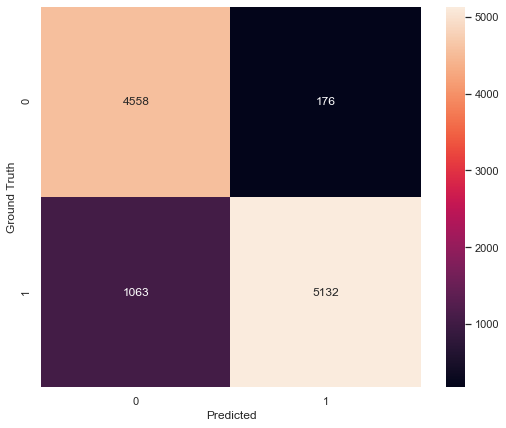

In [37]:
plt.figure(figsize=(9,7))
sn.heatmap(confusionMat, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel("Predicted"); plt.ylabel("Ground Truth"); plt.show()

We can indeed tell that our model is doing a good job!

# 8. Adjusting the Model
Essentially there are three things that we can do
1. Acquiring more data: As things stand we already have plenty of data and cannot acquire more
2. Playing with Hyperparameters: we already specified lasso regression for our model
3. Choosing a different model altogether

## K-Fold cross validation

[K-fold](https://www.youtube.com/watch?v=fSytzGwwBVw) cross validation partitions our data in k-folds (for instance 10) and it iterates in such a way that each fold is used for testing once with the rest of the folds being testing data.

In [38]:
accuracies = cross_val_score(estimator=classifier, X=train_features, y=train_labels, cv=10)
print("Accuracy with a 10-fold cross validation:", round(np.mean(accuracies), 2))

Accuracy with a 10-fold cross validation: 0.89


It looks like the performance is the same!

# 9. Interpret the model and report results visually and numerically

In [39]:
# Combine the results into a final data frame
final_results = pd.concat([test_uid, test_labels], axis=1).dropna()
final_results['predicted'] = predictions
# Reset the indices
final_results = final_results.reset_index(drop=True)
final_results

,user,enrolled,predicted
0,251410,0,0
1,132536,1,0
2,38654,0,0
3,122925,0,0
4,122887,1,1
...,...,...,...
10924,226556,1,1
10925,2645,1,1
10926,42051,1,1
10927,314895,0,0


## Conclusion

Our model will label every new user as highly likely or unlikely to subscribe (and all this within the first 48h). This will ensure that the company only narrows the marketing efforts on those users who appear to be unlikely to subscribe. 

In this small project we saw and end-to end-machine learning example! We saw the data analysis pipeline and finally applied a logistic regression model which achieved a very good precision of **89%.**